Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("drive/MyDrive/Melanoma_Detection_Assignment/data/Train")
data_dir_test = pathlib.Path('drive/MyDrive/Melanoma_Detection_Assignment/data/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir_train,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset = 'training',
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2739 files belonging to 9 classes.
Using 2192 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir_train,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=False,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2739 files belonging to 9 classes.
Using 547 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt
sample_images = {}
for images, labels in train_ds:
    for i in range(len(images)):
        class_name = class_names[tf.argmax(labels[i])]
        if class_name not in sample_images:
            sample_images[class_name] = images[i]
            break
    if len(sample_images) == len(class_names):  # Stop if we have samples for all classes
        break
### your code goes here, you can use training or validation data to visualize

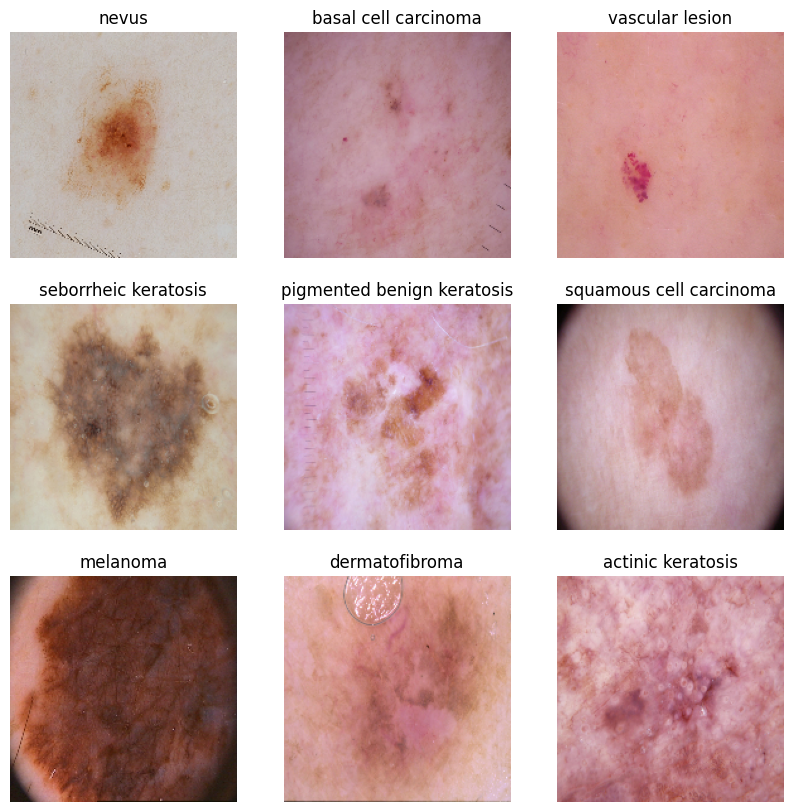

In [ ]:
plt.figure(figsize=(10, 10))
for i, (class_name, image) in enumerate(sample_images.items()):
    plt.subplot(3, 3, i + 1)  # Adjust subplot layout as needed
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing. Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
### Your code goes here
rescaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# batch image is taken in x and label taken in y, rescaling the x with rescaling_layer, while returning y as unchanged
normalized_train_ds = train_ds.map(lambda x,y :(rescaling_layer(x),y))

normalized_val_ds = val_ds.map(lambda x,y : (rescaling_layer(x),y))


In [ ]:
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),

    keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),


    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),

    keras.layers.Dense(9, activation="softmax")
])

# Compiling the model

# optmzr=tf.keras.optimizers.Adam(learning_rate=0.001)
optmzr= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
loss_fnc = 'categorical_crossentropy'
model.compile(optimizer=optmzr,
              loss=loss_fnc,
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 118336)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)
# model.save("drive/MyDrive/Melanoma_Detection_Assignment/model1.h5")
# model = tf.keras.models.load_model("drive/MyDrive/Melanoma_Detection_Assignment/model1.h5")

Epoch 1/20
60/60 [==============================] - 4s 38ms/step - loss: 2.0856 - accuracy: 0.2823 - val_loss: 1.7067 - val_accuracy: 0.4521
Epoch 2/20
60/60 [==============================] - 2s 35ms/step - loss: 1.5543 - accuracy: 0.4526 - val_loss: 1.3014 - val_accuracy: 0.5792
Epoch 3/20
60/60 [==============================] - 2s 41ms/step - loss: 1.4270 - accuracy: 0.5047 - val_loss: 1.1516 - val_accuracy: 0.5625
Epoch 4/20
60/60 [==============================] - 2s 38ms/step - loss: 1.2818 - accuracy: 0.5693 - val_loss: 0.6982 - val_accuracy: 0.7812
Epoch 5/20
60/60 [==============================] - 2s 33ms/step - loss: 1.1350 - accuracy: 0.6135 - val_loss: 0.7387 - val_accuracy: 0.7458
Epoch 6/20
60/60 [==============================] - 2s 35ms/step - loss: 0.9712 - accuracy: 0.6599 - val_loss: 0.4564 - val_accuracy: 0.8479
Epoch 7/20
60/60 [==============================] - 2s 32ms/step - loss: 0.8187 - accuracy: 0.7089 - val_loss: 0.5612 - val_accuracy: 0.8250
Epoch 8/20
60

### Visualizing training results

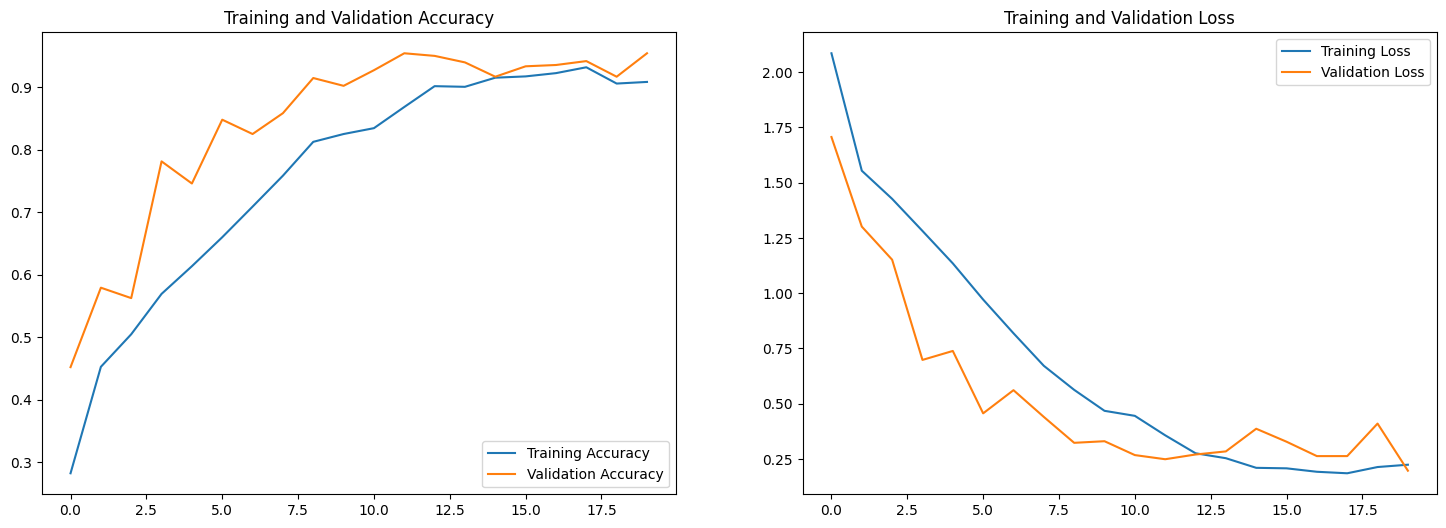

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model.evaluate(normalized_train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(normalized_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


15/15 [==============================] - 0s 12ms/step - loss: 0.1969 - accuracy: 0.9542
Accuracy:  0.9437500238418579
Validation Accuracy:  0.9541666507720947
Loss:  0.1509229838848114
Validation Loss 0.1968846619129181


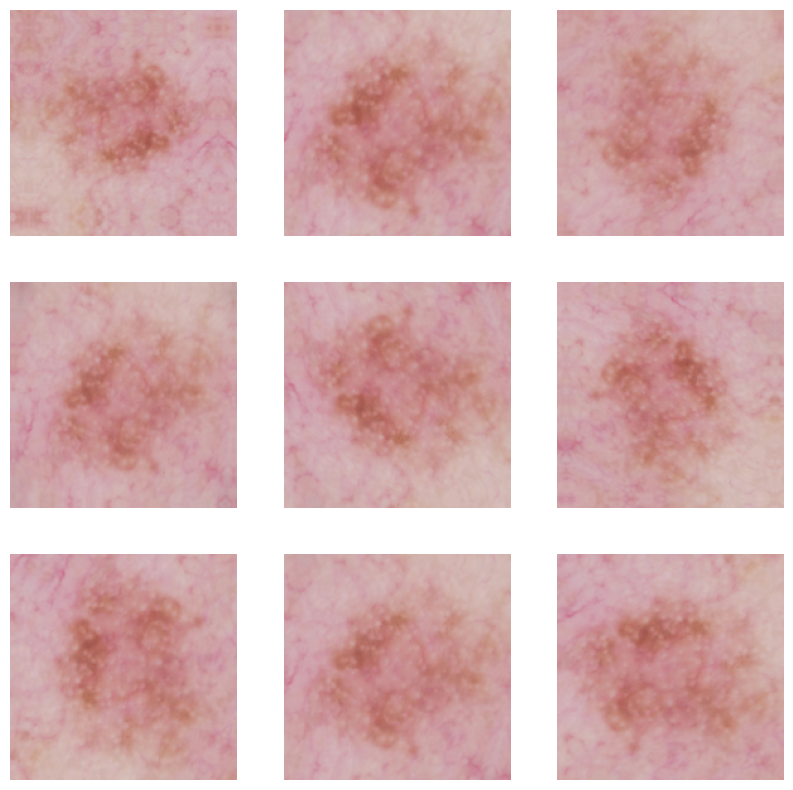

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model2 = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),

    # keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    # keras.layers.experimental.preprocessing.RandomContrast(0.1),

    keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D((2, 2)),


    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),

    keras.layers.Dense(9, activation="softmax")
])

# Compiling the Model
optmzr= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
loss_fnc = 'categorical_crossentropy'
model2.compile(optimizer=optmzr,
              loss=loss_fnc,
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)       

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)
model2.save("drive/MyDrive/Melanoma_Detection_Assignment/model2.h5")
# model2 = tf.keras.models.load_model("drive/MyDrive/Melanoma_Detection_Assignment/model2.h5")

Epoch 1/20
60/60 [==============================] - 8s 66ms/step - loss: 2.3131 - accuracy: 0.2599 - val_loss: 1.6211 - val_accuracy: 0.5417
Epoch 2/20
60/60 [==============================] - 4s 67ms/step - loss: 1.7560 - accuracy: 0.3562 - val_loss: 1.7981 - val_accuracy: 0.4417
Epoch 3/20
60/60 [==============================] - 4s 64ms/step - loss: 1.5753 - accuracy: 0.4745 - val_loss: 0.9691 - val_accuracy: 0.6646
Epoch 4/20
60/60 [==============================] - 4s 63ms/step - loss: 1.5498 - accuracy: 0.4604 - val_loss: 0.9596 - val_accuracy: 0.6750
Epoch 5/20
60/60 [==============================] - 4s 67ms/step - loss: 1.4318 - accuracy: 0.5052 - val_loss: 1.0459 - val_accuracy: 0.5938
Epoch 6/20
60/60 [==============================] - 4s 68ms/step - loss: 1.4065 - accuracy: 0.5250 - val_loss: 0.8753 - val_accuracy: 0.6500
Epoch 7/20
60/60 [==============================] - 4s 61ms/step - loss: 1.3322 - accuracy: 0.5318 - val_loss: 0.7999 - val_accuracy: 0.6708
Epoch 8/20
60

### Visualizing the results

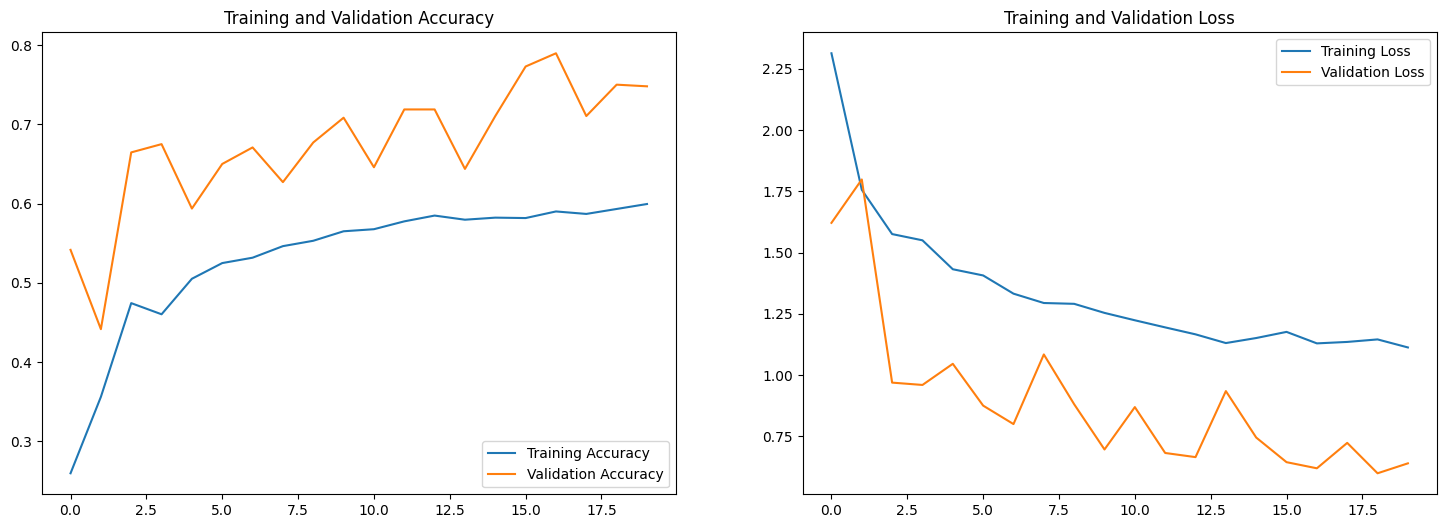

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model2.evaluate(normalized_train_ds, verbose=1,)
loss_v, accuracy_v = model2.evaluate(normalized_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 13ms/step - loss: 0.6397 - accuracy: 0.7479
Accuracy:  0.6427083611488342
Validation Accuracy:  0.7479166388511658
Loss:  0.9948865175247192
Validation Loss 0.6397475600242615


### Findings
- With Droppout and data augmentation , the model started performing poorly
- Various combinations of data augmentation and droppout didn't help to cross validation accuracy to above 0.5
- At current state, the model performs worse than random guesser

### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

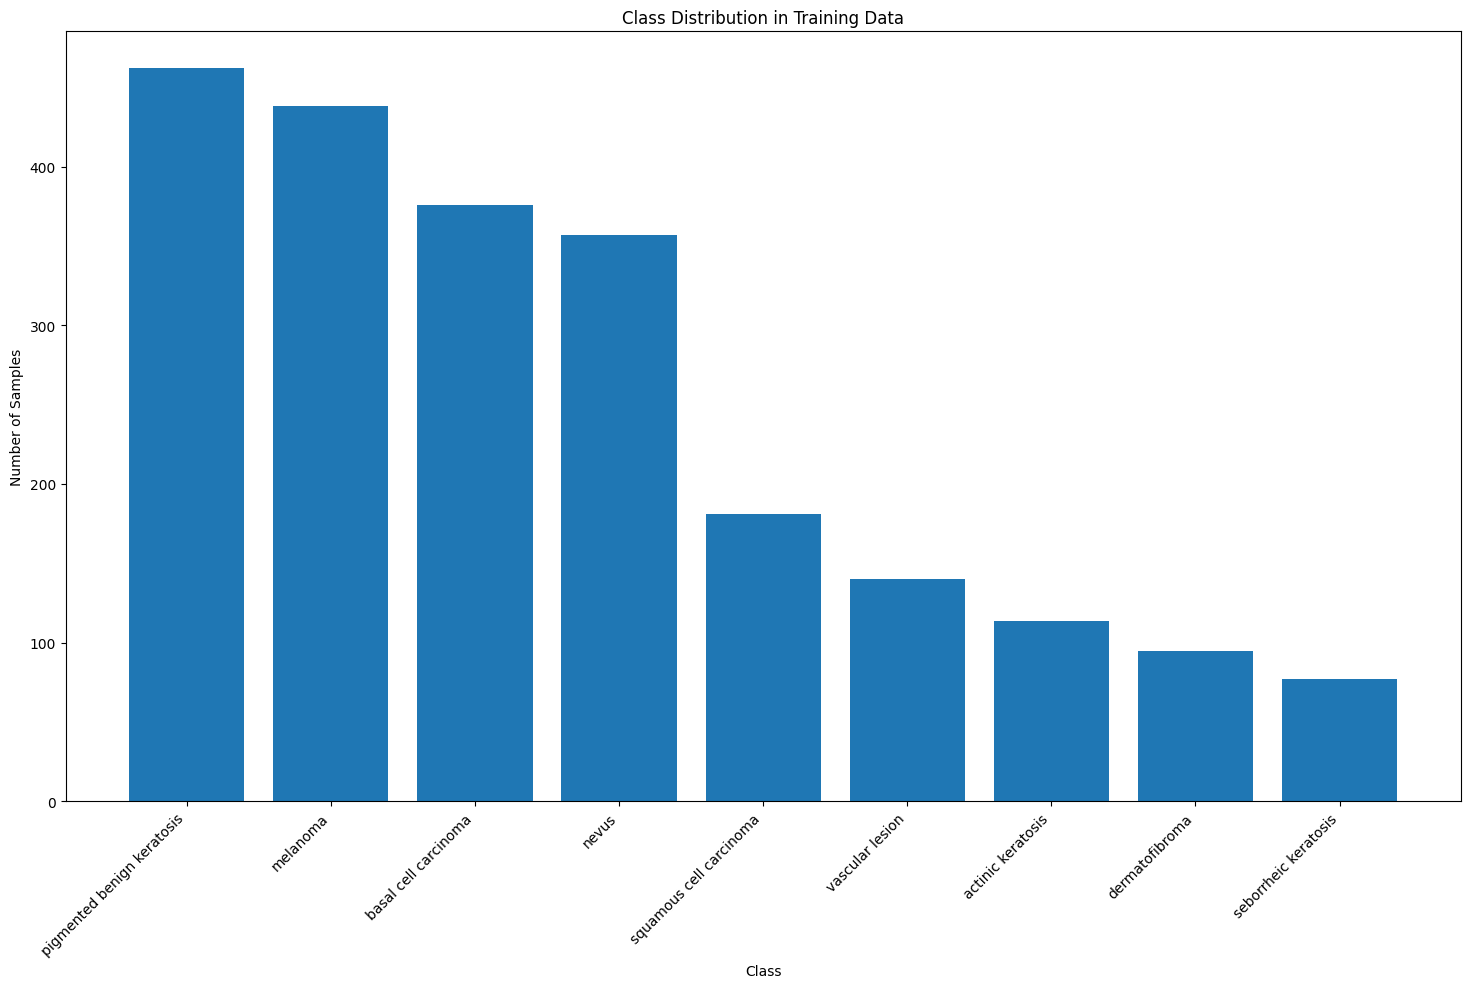

In [ ]:
data_path = 'drive/MyDrive/Melanoma_Detection_Assignment/data/Train'
class_counts = {}
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    class_counts[class_folder] = len(os.listdir(class_path))

sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)


plt.figure(figsize=(18,10))
plt.bar(range(len(sorted_class_counts)), [count for _, count in sorted_class_counts])
plt.xticks(range(len(sorted_class_counts)), [name for name, _ in sorted_class_counts], rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Data")
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? - **Seborrheic Keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? - **Pigmented Benign Keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your
`Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EDE53664A0>: 100%|██████████| 500/500 [00:19<00:00, 25.24 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EDE37C0760>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE67D87BB0>: 100%|██████████| 500/500 [00:21<00:00, 23.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78EDE48AAAA0>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EDE26F0070>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EDE4A2E260>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78EDE2639A80>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE400824D0>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/MyDrive/Melanoma_Detection_Assignment/data_aug/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EDE4A2E260>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [5]:
data_dir_train=pathlib.Path("drive/MyDrive/Melanoma_Detection_Assignment/data_aug2")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [6]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_c9cec887-6cd6-40b9-9374-2905a1f706d3.jpg',
 'drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_0bd9c3e1-1c29-4b78-aa0f-4199346d2f03.jpg',
 'drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_38a930db-4571-48cf-a75e-571e30321387.jpg',
 'drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_4f5c2dac-0e61-4b68-92cb-5abcf6e74b01.jpg',
 'drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_a6863462-70a5-41b5-b558-d9742d5aedae.jpg',
 'drive/MyDrive/Melanoma_Detection_Assignment/data_aug2/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_81aaf6ba-196c-415a-9b30-d15a07c3109

In [7]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [8]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [9]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [10]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [11]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [12]:
data_dir_train=pathlib.Path("drive/MyDrive/Melanoma_Detection_Assignment/data_aug2")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [14]:
### Your code goes here
rescaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# batch image is taken in x and label taken in y, rescaling the x with rescaling_layer, while returning y as unchanged
normalized_train_ds = train_ds.map(lambda x,y :(rescaling_layer(x),y))

normalized_val_ds = val_ds.map(lambda x,y : (rescaling_layer(x),y))


#### **Todo:** Create your model (make sure to include normalization) - Added above to reduce computational time

In [15]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model3 = keras.Sequential([

    keras.Input(shape=(180, 180, 3)),

    keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),

    keras.layers.Dense(9, activation="softmax")
])

# Compiling the Model
optmzr= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
loss_fnc = 'categorical_crossentropy'
model3.compile(optimizer=optmzr,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 128)               1

#### **Todo:**  Train your model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
epochs = 20
history3 = model3.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
  # callbacks=[learn_control]
)

Epoch 1/20
169/169 [==============================] - 46s 255ms/step - loss: 1.7969 - accuracy: 0.3246 - val_loss: 1.5394 - val_accuracy: 0.4024
Epoch 2/20
169/169 [==============================] - 44s 253ms/step - loss: 1.3607 - accuracy: 0.5017 - val_loss: 1.3539 - val_accuracy: 0.4937
Epoch 3/20
169/169 [==============================] - 45s 259ms/step - loss: 1.1584 - accuracy: 0.5779 - val_loss: 1.1703 - val_accuracy: 0.5768
Epoch 4/20
169/169 [==============================] - 43s 249ms/step - loss: 0.9363 - accuracy: 0.6701 - val_loss: 1.0207 - val_accuracy: 0.6325
Epoch 5/20
169/169 [==============================] - 45s 257ms/step - loss: 0.7123 - accuracy: 0.7468 - val_loss: 0.8665 - val_accuracy: 0.7008
Epoch 6/20
169/169 [==============================] - 44s 254ms/step - loss: 0.5583 - accuracy: 0.8006 - val_loss: 0.8284 - val_accuracy: 0.7268
Epoch 7/20
169/169 [==============================] - 42s 242ms/step - loss: 0.3979 - accuracy: 0.8570 - val_loss: 0.8208 - val_ac

#### **Todo:**  Visualize the model results

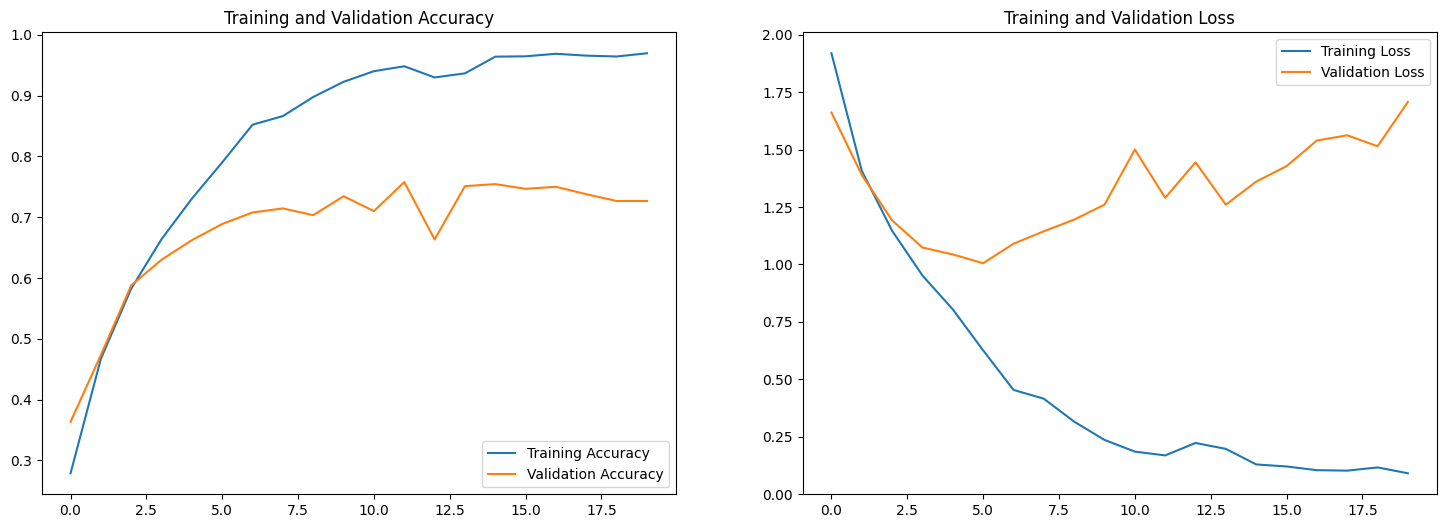

In [20]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model3.evaluate(normalized_train_ds, verbose=1,)
loss_v, accuracy_v = model3.evaluate(normalized_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


29/29 [==============================] - 4s 104ms/step - loss: 1.7077 - accuracy: 0.7267
Accuracy:  0.9527778029441833
Validation Accuracy:  0.7266666889190674
Loss:  0.12831611931324005
Validation Loss 1.707738995552063


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Class rebalance doesn't seem to have helped much, now the model went overfitting

In [22]:
# Trying dropout to see if improvements can be made

model4 = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),

    keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D((2, 2)),


    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),

    keras.layers.Dense(9, activation="softmax")
])

# Compiling the Model
optmzr= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
loss_fnc = 'categorical_crossentropy'
model4.compile(optimizer=optmzr,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                 

In [23]:
epochs = 20
history4 = model4.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)
model4.save("drive/MyDrive/Melanoma_Detection_Assignment/model4.h5")
model4.save("drive/MyDrive/Melanoma_Detection_Assignment/model4.keras")
# model3 = tf.keras.models.load_model("drive/MyDrive/Melanoma_Detection_Assignment/model4.h5")

Epoch 1/20
113/113 [==============================] - 26s 195ms/step - loss: 2.2164 - accuracy: 0.2139 - val_loss: 1.8283 - val_accuracy: 0.3256
Epoch 2/20
113/113 [==============================] - 23s 196ms/step - loss: 1.6184 - accuracy: 0.3672 - val_loss: 1.7258 - val_accuracy: 0.3511
Epoch 3/20
113/113 [==============================] - 27s 231ms/step - loss: 1.4188 - accuracy: 0.4644 - val_loss: 1.6522 - val_accuracy: 0.3556
Epoch 4/20
113/113 [==============================] - 24s 194ms/step - loss: 1.2611 - accuracy: 0.5417 - val_loss: 1.2745 - val_accuracy: 0.5789
Epoch 5/20
113/113 [==============================] - 24s 201ms/step - loss: 1.0115 - accuracy: 0.6378 - val_loss: 1.2173 - val_accuracy: 0.5878
Epoch 6/20
113/113 [==============================] - 25s 208ms/step - loss: 0.8516 - accuracy: 0.7083 - val_loss: 1.1222 - val_accuracy: 0.6256
Epoch 7/20
113/113 [==============================] - 24s 201ms/step - loss: 0.6996 - accuracy: 0.7719 - val_loss: 1.0875 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


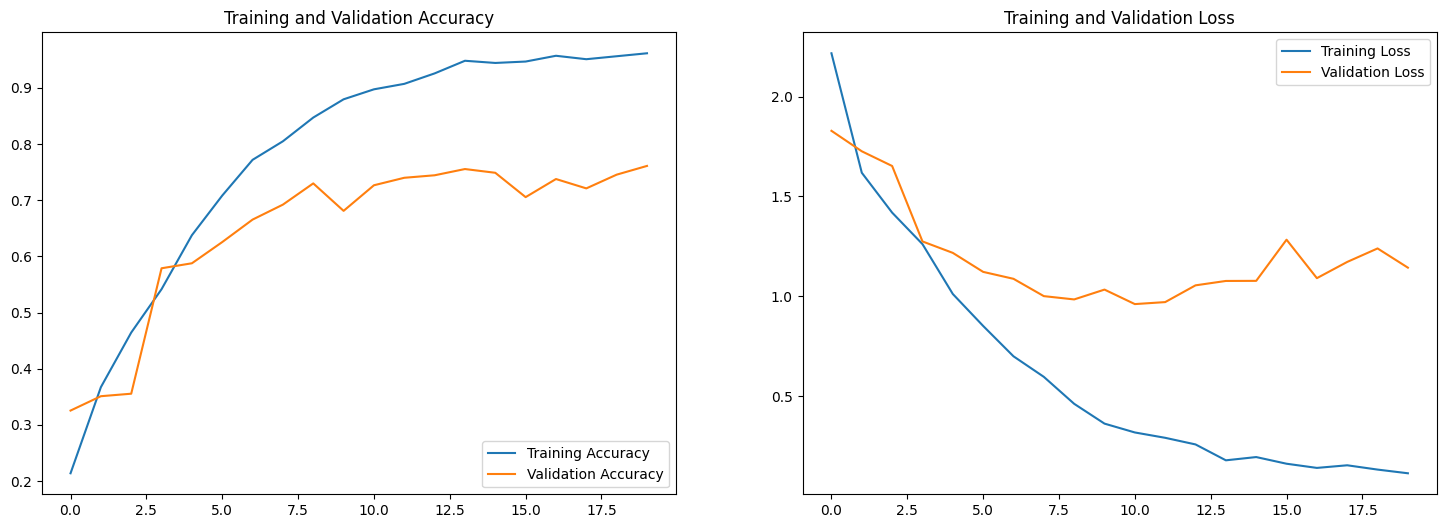

In [24]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model4.evaluate(normalized_train_ds, verbose=1,)
loss_v, accuracy_v = model4.evaluate(normalized_val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


29/29 [==============================] - 4s 108ms/step - loss: 1.1433 - accuracy: 0.7611
Accuracy:  0.977222204208374
Validation Accuracy:  0.7611111402511597
Loss:  0.07727986574172974
Validation Loss 1.1432942152023315


**We started with a simple model, which seem to be performing good. But initial Augmentation didn't provide much improvment**
- as I can understand the hystopatholigical slides will not be having zoom/contrast/flip variance as compared to other real life photos ( all images will be sampled in similar fashion under similar microscope)
- Rotation and Flip will not play much crucial roles here. most of the patterns seem to be spread evenly all sides, unlike other images (eg: human face has a structure top to down).
- Being simpler model with comparitively limited number of data dropout didn't help


**After class imbalance**
- we used 4500 generated image for training. it showed signs of overfitting
- Dropout actually helped, but the initial performance were not achieved here